In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
!pip install openpyxl
import os
import requests
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
!pip install libpysal
!pip install esda
!pip install pysal
from esda.getisord import G_Local
from libpysal.weights import Queen
from matplotlib.colors import SymLogNorm
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from scipy.stats import ttest_ind
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
from Getis_Ord import *

# Specifications

In [2]:
save = False

# Load County-Aggregated Policy Data

In [3]:
# Load aggregated sum policies by state
policies = pd.read_csv("../Local_Data/NFIP_Data/policy_total_county_averages.csv")

# Filter out rows with missing or blank values in the relevant columns
policies = policies.dropna(subset=['countyCode', 'policyCost_mean', 'totalInsurancePremiumOfThePolicy_mean'])
policies['countyCode'] = policies['countyCode'].astype(int).astype(str)
policies['countyCode'] = policies['countyCode'].apply(lambda x: str(x).zfill(5))
policies['oldest_year'] = policies['oldest_year'] -1 
policies['most_recent_year'] = policies['most_recent_year'] -1 

# Load Risk Rating 2.0 Data

In [4]:
risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

risk_policies['County'] = risk_policies['County'].str.strip()
risk_policies['State'] = risk_policies['State'].str.strip()

aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
    'Policies in Force': 'sum',
    'Total Coverage': 'sum',
    'Total Written Premium + FPF': 'sum',
    'Total Annual Payment': 'sum'
}).reset_index()

## Map Fips to appropriate county

In [5]:
# Read the file line by line
with open('../Local_Data/fips_codes.txt', 'r') as file:
    lines = file.readlines()

# Identify where state-level data starts and ends
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # State data starts after the "state-level" heading
    if "county-level" in line.lower():
        county_section_start = i + 2  # County data starts after the "county-level" heading
        break

# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

# Split the data into sections
state_section_start = 0
county_section_start = 0

for i, line in enumerate(lines):
    if "state-level" in line.lower():
        state_section_start = i + 2  # Skip the header lines
    if "county-level" in line.lower():
        county_section_start = i + 2  # Skip the header lines
        break

state_lines = lines[state_section_start:county_section_start-2]  # State data lines
county_lines = lines[county_section_start:]  # County data line

# Parse county data
county_fips = []
county_name = []

for line in county_lines:
    line = line.strip()
    if len(line) > 12 and line[:5].isdigit():
        county_fips_code = line[:5].strip()
        county_fips_name = line[12:].strip()
        county_fips.append(county_fips_code)
        county_name.append(county_fips_name)

county_df = pd.DataFrame({
    'countyCode': county_fips,
    'County Name': county_name
})

county_df['State FIPS'] = county_df['countyCode'].str[:2]  # Extract state FIPS from the countyCode

# Merge
fips_df = county_df.merge(state_df, on='State FIPS')
fips_df['County Name'] = fips_df['County Name'].str.upper()

In [6]:
# Ensure that County and State names are fully capitalized in the aggregated_risk_policies DataFrame
aggregated_risk_policies['County'] = aggregated_risk_policies['County'].str.upper()
aggregated_risk_policies['State'] = aggregated_risk_policies['State'].str.upper()

# Merge the DataFrames
aggregated_risk_policies = aggregated_risk_policies.merge(fips_df, left_on=['County', 'State'], right_on=['County Name', 'State Name'], how='left')

# Drop unnecessary columns (optional)
aggregated_risk_policies = aggregated_risk_policies.drop(columns=['County Name', 'State Name'])

# Load Clustered Claims Data

In [7]:
# Load claims data
claims = pd.read_csv("clustered_claims_final.csv", low_memory=False)

# Load Shapefiles of Interest

In [8]:
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Data Merging and Preprocess

## County Contributions

In [9]:
# Filter out rows with missing or blank values in the relevant columns
filtered_data = claims.dropna(subset=['countyCode', 'buildingDamageAmount', 'buildingPropertyValue', 'adjustedClaim', 'yearOfLoss'])
filtered_data['countyCode'] = filtered_data['countyCode'].astype(int).astype(str)
filtered_data['countyCode'] = filtered_data['countyCode'].apply(lambda x: str(x).zfill(5))
filtered_data['mitigatedClaim'] = filtered_data['elevatedBuildingIndicator'] | filtered_data['floodproofedIndicator']

# Aggregate the data by countyCode and yearOfLoss
aggregated_yearly_data = filtered_data.groupby(['countyCode', 'yearOfLoss']).agg({
    'adjustedClaim':'sum',
    'buildingDamageAmount': 'sum',
    'buildingPropertyValue': 'sum',
    'mitigatedClaim':'mean'
}).reset_index()

# Count the number of years available for each county and track min and max year
years_stats = aggregated_yearly_data.groupby('countyCode').agg({
    'yearOfLoss': ['count', 'min', 'max']
}).reset_index()

# Flatten the multi-level columns after aggregation
years_stats.columns = ['countyCode', 'years_averaged', 'min_yearOfLoss', 'max_yearOfLoss']

# Sum the yearly data across all years for each county
aggregated_county_data = aggregated_yearly_data.groupby('countyCode').agg({
    'adjustedClaim':'sum',
    'buildingDamageAmount': 'sum',
    'buildingPropertyValue': 'sum',
    'mitigatedClaim':'mean'
}).reset_index()

# Merge with the years_stats to keep track of the number of years averaged over, min, and max years
aggregated_county_data = pd.merge(aggregated_county_data, years_stats, on='countyCode')

# Merge the two DataFrames on 'countyCode'
merged_data = pd.merge(aggregated_county_data, policies, on='countyCode', how='inner', suffixes=('_claims', '_policies'))

# Calculate the minimum of the two min_yearOfLoss and the maximum of the two max_yearOfLoss
merged_data['min_yearOfLoss'] = merged_data[['min_yearOfLoss', 'oldest_year']].min(axis=1)
merged_data['max_yearOfLoss'] = merged_data[['max_yearOfLoss', 'most_recent_year']].max(axis=1)

# Calculate the total number of years (max - min + 1)
merged_data['total_years'] = merged_data['max_yearOfLoss'] - merged_data['min_yearOfLoss'] + 1

# Drop the original min/max columns if no longer needed
merged_data = merged_data.drop(columns=['min_yearOfLoss', 'oldest_year', 'max_yearOfLoss', 'most_recent_year'])

# Calculate the mean yearly value by dividing by the actual number of years present for each county
merged_data['mean_adjustedClaim'] = merged_data['adjustedClaim'] / merged_data['total_years']
merged_data['mean_buildingDamageAmount'] = merged_data['buildingDamageAmount'] / merged_data['total_years']
merged_data['mean_buildingPropertyValue'] = merged_data['buildingPropertyValue'] / merged_data['total_years']

# Reset index to keep the final structure
merged_data.reset_index(drop=True, inplace=True)

# Mean Loss
merged_data['meanLoss_hist'] = merged_data['totalInsurancePremiumOfThePolicy_mean']-merged_data['mean_adjustedClaim']

# Merge the two DataFrames on 'countyCode'
merged_data = pd.merge(merged_data, aggregated_risk_policies, on='countyCode', how='inner', suffixes=('_claims', '_policies'))

# Mean Loss
merged_data['meanLoss'] = merged_data['Total Written Premium + FPF']-merged_data['mean_adjustedClaim']

# Loss per HH Insured
merged_data['lossPerInsured'] = merged_data['meanLoss']/merged_data['Policies in Force']

# Optionally save the merged data
merged_data.to_csv('nfip_merged_county_data_RR2.csv', index=False)

# Merge the aggregated data with the shapefile
gdf_counties = gdf_counties.merge(merged_data, left_on='GEOID', right_on='countyCode', how='left')

# Getis-Ord Hotspot Analysis

In [10]:
# Run for meanLoss
gdf_counties = run_getis_ord_analysis(gdf_counties, "meanLoss")

# Figure 2

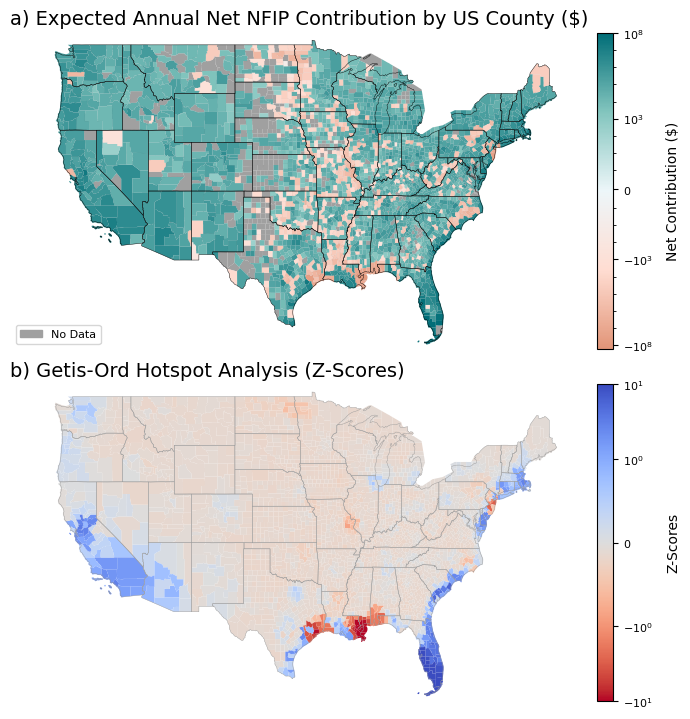

In [11]:
# Create the figure and axes for the subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.08, 7.08), constrained_layout=True)

# Plot 1: Expected Annual Net NFIP Contribution by US County ($)
# Define the custom color palette for the first plot
colors = [
    '#e29578',  # Dark red for negative values
    '#ffddd2',  # Light red for negative values near 0
    '#edf6f9',  # Gray for values near 0
    '#83c5be',  # Light blue for positive values near 0
    '#006d77'   # Dark blue for positive values
]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
linthresh = 1
sym_norm = mcolors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-179965441, vmax=106213551, base=10)

no_data_color = '#a0a0a0'  # Slightly lighter gray

orig_no_data_mask = gdf_counties['meanLoss'].isna() if gdf_counties['meanLoss'].isna().any() else (gdf_counties['meanLoss'] == 0)

# --- Clean geometries (avoid empty/NaN) ---
gdf_counties = gdf_counties[gdf_counties.geometry.notna() & ~gdf_counties.geometry.is_empty].copy()

# --- NO-DATA layer: only plot if non-empty ---
gdf_no_data = gdf_counties[orig_no_data_mask]
if not gdf_no_data.empty:
    gdf_no_data.plot(ax=ax1, color=no_data_color, linewidth=0.01, edgecolor='0.6', aspect='equal')

# --- DATA layer: exclude no-data and plot ---
gdf_has_data = gdf_counties[~orig_no_data_mask]
if not gdf_has_data.empty:
    gdf_has_data.plot(
        column='meanLoss', cmap=cmap, linewidth=0.01, ax=ax1, edgecolor='0.1',
        norm=sym_norm, aspect='equal'  # bypass auto-aspect derived from bounds
    )

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.3)

# Add title, extent, and label
ax1.set_title('a) Expected Annual Net NFIP Contribution by US County ($)', fontsize=14, loc='left')
ax1.set_xlim(-130, -65)
ax1.set_ylim(24, 50)
ax1.axis('off')

# Add a custom legend for "No Data"
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
ax1.legend(handles=[no_data_patch], loc='lower left', fontsize=8)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=sym_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_ticks([-100000000, -1000, 0, 1000, 100000000])
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Net Contribution ($)', fontsize=10, labelpad=10)

# Plot 2: Z-Scores (Getis-Ord Hotspot Analysis)
cmap = plt.get_cmap('coolwarm_r')
norm = SymLogNorm(linthresh=1, vmin=-10, vmax=10, base=10)
gdf_counties.plot(column='Z_Scores_meanLoss', linewidth=0.01, norm=norm, cmap=cmap, ax=ax2)

# Plot the state borders on top with a darker color and thicker line
gdf_states.boundary.plot(ax=ax2, edgecolor='0.6', linewidth=0.3)

# Add a custom colorbar
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', fraction=0.03, pad=0.04)
cbar2.set_ticks([-10, -1, 0, 1, 10])
cbar2.ax.tick_params(labelsize=8)
cbar2.set_label('Z-Scores', fontsize=10, labelpad=10)

# Add title, extent, and label
ax2.set_title('b) Getis-Ord Hotspot Analysis (Z-Scores)', fontsize=14, loc='left')
ax2.set_xlim(-130, -65)
ax2.set_ylim(24, 50)
ax2.axis('off')

# Show the final combined plot
if save:
    output_path = 'Plots/F1_Net_Contribution_Hotspot.png'
    plt.savefig(output_path, dpi=500, bbox_inches='tight')
plt.show()